# Install SLEAP
Don't forget to set **Runtime** -> **Change runtime type...** -> **GPU** as the accelerator.

In [1]:
!pip -q install sleap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.1/904.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sleap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sleap.versions()

SLEAP: 1.3.0
TensorFlow: 2.8.4
Numpy: 1.22.4
Python: 3.10.11
OS: Linux-5.10.147+-x86_64-with-glibc2.31


# Download training data

In [3]:
!curl -L --output labels.slp https://www.dropbox.com/s/b990gxjt3d3j3jh/210205.sleap_wt_gold.13pt.pkg.slp?dl=1
!ls -lah

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     49      0 --:--:-- --:--:-- --:--:--    49
100   363  100   363    0     0    392      0 --:--:-- --:--:-- --:--:--   392
100  773M  100  773M    0     0  76.8M      0  0:00:10  0:00:10 --:--:-- 95.2M
total 774M
drwxr-xr-x 1 root root 4.0K Apr 29 08:20 .
drwxr-xr-x 1 root root 4.0K Apr 29 08:17 ..
drwxr-xr-x 4 root root 4.0K Apr 27 13:34 .config
-rw-r--r-- 1 root root 774M Apr 29 08:20 labels.slp
drwxr-xr-x 1 root root 4.0K Apr 27 13:35 sample_data


# Load the training data

In [4]:
# SLEAP Labels files (.slp) can include the images as well as labeled instances and
# other metadata for a project.
labels = sleap.load_file("labels.slp")
labels = labels.with_user_labels_only()
labels.describe()

Skeleton: Skeleton(description=None, nodes=[head, thorax, abdomen, wingL, wingR, forelegL4, forelegR4, midlegL4, midlegR4, hindlegL4, hindlegR4, eyeL, eyeR], edges=[thorax->head, thorax->abdomen, thorax->wingL, thorax->wingR, thorax->forelegL4, thorax->forelegR4, thorax->midlegL4, thorax->midlegR4, thorax->hindlegL4, thorax->hindlegR4, head->eyeL, head->eyeR], symmetries=[eyeL<->eyeR, forelegL4<->forelegR4, wingL<->wingR, hindlegL4<->hindlegR4, midlegL4<->midlegR4])
Videos: ['labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp']
Frames (user/predicted): 2,000/0
Instances (user/predicted): 4,000/0
Tracks: [Track(spawned_on=0, na

In [5]:
# Labels are list-like containers whose elements are LabeledFrames
print(f"Number of labels: {len(labels)}")

labeled_frame = labels[0]
labeled_frame

Number of labels: 2000


LabeledFrame(video=HDF5Video('labels.slp'), frame_idx=7455, instances=2)

In [6]:
# LabeledFrames are containers for instances that were labeled in a single frame
instance = labeled_frame[0]
instance

Instance(video=Video(filename=labels.slp, shape=(55, 1024, 1024, 1), backend=HDF5Video), frame_idx=7455, points=[head: (633.5, 806.0), thorax: (589.2, 807.0), abdomen: (557.2, 813.5), wingL: (538.7, 812.6), wingR: (538.9, 814.8), forelegL4: (652.0, 797.0), forelegR4: (655.2, 814.1), midlegL4: (611.5, 779.4), midlegR4: (614.1, 862.1), hindlegL4: (540.4, 778.7), hindlegR4: (570.8, 843.3), eyeL: (621.4, 795.1), eyeR: (622.4, 816.8)], track=Track(spawned_on=0, name='female'))

In [7]:
# They can be converted to numpy arrays where each row corresponds to the coordinates
# of a different body part:
pts = instance.numpy()
pts

rec.array([[633.53948229, 806.03863528],
           [589.19035306, 807.03863528],
           [557.15087078, 813.50056467],
           [538.69299954, 812.58872353],
           [538.94660133, 814.78180105],
           [652.00028234, 797.03863528],
           [655.24461549, 814.09569239],
           [611.5       , 779.38494116],
           [614.08309628, 862.14672415],
           [540.41406264, 778.65699169],
           [570.76953595, 843.28358376],
           [621.39804036, 795.0546654 ],
           [622.35635663, 816.77982951]],
          dtype=float64)

# Setup training data generation

For a top-down pipeline, the subnetwork (*centered instance model*) that takes cropped images as input and produces pose estimates as output requires **confidence maps** to train against as targets.

Here we will create a pipeline that does the sampling, augmentation, data generation and
batching so we can create our input/output pairs.

In [8]:
# Initialize a pipeline from the labels.
p = labels.with_user_labels_only().to_pipeline()

# This pipeline will output dictionaries with tensors containing frame data:
p.describe()

         image: type=EagerTensor, shape=(1024, 1024, 1), dtype=tf.uint8, device=/job:localhost/replica:0/task:0/device:CPU:0
raw_image_size: type=EagerTensor, shape=(3,), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
   example_ind: type=EagerTensor, shape=(), dtype=tf.int64, device=/job:localhost/replica:0/task:0/device:CPU:0
     video_ind: type=EagerTensor, shape=(), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
     frame_ind: type=EagerTensor, shape=(), dtype=tf.int64, device=/job:localhost/replica:0/task:0/device:CPU:0
         scale: type=EagerTensor, shape=(2,), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
     instances: type=EagerTensor, shape=(2, 13, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
 skeleton_inds: type=EagerTensor, shape=(2,), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
    track_inds: type=EagerTensor, shape=(2,), dtype=tf.int32, device=/job

In [9]:
# Let's add some transformations necessary for the centered-instance model.
p = labels.with_user_labels_only().to_pipeline()
p += sleap.pipelines.ImgaugAugmenter.from_config(sleap.pipelines.AugmentationConfig(rotate=True, rotation_min_angle=-180, rotation_max_angle=180))
p += sleap.pipelines.Normalizer()
p += sleap.pipelines.InstanceCentroidFinder(center_on_anchor_part=True, anchor_part_names="thorax", skeletons=labels.skeletons)
p += sleap.pipelines.InstanceCropper(crop_width=160, crop_height=160)
p += sleap.pipelines.InstanceConfidenceMapGenerator(sigma=1.5, output_stride=2)
p += sleap.pipelines.Batcher(batch_size=4, drop_remainder=True)
p.describe()

          instance_image: type=EagerTensor, shape=(4, 160, 160, 1), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
                    bbox: type=EagerTensor, shape=(4, 4), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
         center_instance: type=EagerTensor, shape=(4, 13, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
     center_instance_ind: type=EagerTensor, shape=(4, 1), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
               track_ind: type=EagerTensor, shape=(4, 1), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
           all_instances: type=EagerTensor, shape=(4, 2, 13, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
                centroid: type=EagerTensor, shape=(4, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
       full_image_height: type=EagerTensor, shape=(4, 1), dtype=tf.int32, device=/job:l

<class 'dict'>
dict_keys(['instance_image', 'bbox', 'center_instance', 'center_instance_ind', 'track_ind', 'all_instances', 'centroid', 'full_image_height', 'full_image_width', 'raw_image_size', 'example_ind', 'video_ind', 'frame_ind', 'scale', 'skeleton_inds', 'track_inds', 'n_tracks', 'instance_confidence_maps'])
(4, 80, 80, 13)


Text(0.5, 1.0, 'Confidence maps (output)')

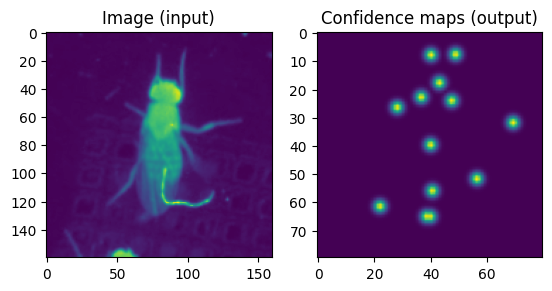

In [10]:
# We can generate an example from the pipeline to play around with the data:
ex = p.peek()
print(type(ex))
print(ex.keys())
print(ex["instance_confidence_maps"].shape)

i = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex["instance_image"][i].numpy().squeeze())
plt.title("Image (input)")
plt.subplot(1,2,2)
plt.imshow(ex["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("Confidence maps (output)")

# Setting up a neural network model

Here we'll create a simple UNet CNN that is compatible with the input and output shapes
that we're generating.

In [11]:
# Instantiate the backbone builder.
unet = sleap.nn.architectures.unet.UNet(filters=32, filters_rate=1.5, down_blocks=4, up_blocks=3, up_interpolate=True)

# Create the input layer (see above for the dimensions)
x_in = tf.keras.layers.Input((160, 160, 1))

# Create the feature extractor backbone.
x_features, x_intermediate = unet.make_backbone(x_in)

# Do a 1x1 conv with linear activation to remap activations to the number of channels in
# the confidence maps (see above)
x_confmaps = tf.keras.layers.Conv2D(filters=13, kernel_size=1, strides=1, padding="same")(x_features)

# Create a Model that links the whole graph
model = tf.keras.Model(x_in, x_confmaps)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 stack0_enc0_conv0 (Conv2D)     (None, 160, 160, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stack0_enc0_act0_relu (Activat  (None, 160, 160, 32  0          ['stack0_enc0_conv0[0][0]']      
 ion)                           )                                                             

In [12]:
model.save('my_model.h5')

# Train the model

Now we have everything we need to do basic training!

Let's set up a custom training loop that trains on each batch of data from our pipeline.

See [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) for more info on how to customize the training process in TensorFlow.

In [ ]:
# Setup the optimizer and loss function.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

# Define a "training step" function. This does the forward/backward passes and applies
# the gradients to update the model weights.
@tf.function
def train_step(ex):
    with tf.GradientTape() as tape:
        predicted_confmaps = model(ex["instance_image"])
        loss_value = loss_fn(ex["instance_confidence_maps"], predicted_confmaps)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

# Training loop, go!
epochs = 3
for epoch in range(epochs):
    for step, ex in enumerate(p.make_dataset()):
        loss_val = train_step(ex)
        if step % 100 == 0:
            print(f"Epoch {epoch:03d} | Step {step:03d} | loss = {loss_val:.5f}")

Epoch 000 | Step 000 | loss = 0.00110
Epoch 000 | Step 100 | loss = 0.00109
Epoch 000 | Step 200 | loss = 0.00104
Epoch 000 | Step 300 | loss = 0.00106
Epoch 000 | Step 400 | loss = 0.00098
Epoch 000 | Step 500 | loss = 0.00102
Epoch 000 | Step 600 | loss = 0.00097
Epoch 000 | Step 700 | loss = 0.00092
Epoch 000 | Step 800 | loss = 0.00093
Epoch 000 | Step 900 | loss = 0.00093
Epoch 001 | Step 000 | loss = 0.00083
Epoch 001 | Step 100 | loss = 0.00086
Epoch 001 | Step 200 | loss = 0.00081
Epoch 001 | Step 300 | loss = 0.00079
Epoch 001 | Step 400 | loss = 0.00078
Epoch 001 | Step 500 | loss = 0.00079
Epoch 001 | Step 600 | loss = 0.00072
Epoch 001 | Step 700 | loss = 0.00084
Epoch 001 | Step 800 | loss = 0.00074
Epoch 001 | Step 900 | loss = 0.00073
Epoch 002 | Step 000 | loss = 0.00077
Epoch 002 | Step 100 | loss = 0.00063
Epoch 002 | Step 200 | loss = 0.00059
Epoch 002 | Step 300 | loss = 0.00066
Epoch 002 | Step 400 | loss = 0.00065
Epoch 002 | Step 500 | loss = 0.00067
Epoch 002 | 

Cool! We did some training -- let's visualize how well the model is doing so far:

<class 'dict'>
dict_keys(['instance_image', 'bbox', 'center_instance', 'center_instance_ind', 'all_instances', 'centroid', 'full_image_height', 'full_image_width', 'raw_image_size', 'example_ind', 'video_ind', 'frame_ind', 'scale', 'skeleton_inds', 'instance_confidence_maps'])
(4, 80, 80, 13)


Text(0.5, 1.0, 'Predicted confidence maps (output)')

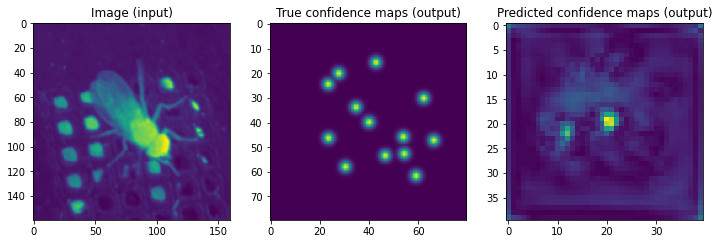

In [ ]:
ex = p.peek()
print(type(ex))
print(ex.keys())
print(ex["instance_confidence_maps"].shape)

predicted_confmaps = model(ex["instance_confidence_maps"])

i = 0
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(ex["instance_image"][i].numpy().squeeze())
plt.title("Image (input)")
plt.subplot(1,3,2)
plt.imshow(ex["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("True confidence maps (output)")
plt.subplot(1,3,3)
plt.imshow(predicted_confmaps[i].numpy().max(axis=-1))
plt.title("Predicted confidence maps (output)")

Not so great huh? Train a while longer and see how we do then.

In [ ]:
epochs = 20
for epoch in range(epochs):
    for step, ex in enumerate(p.make_dataset()):
        loss_val = train_step(ex)
        if step % 100 == 0:
            print(f"Epoch {epoch:03d} | Step {step:03d} | loss = {loss_val:.5f}")

Epoch 000 | Step 000 | loss = 0.00069
Epoch 000 | Step 100 | loss = 0.00052
Epoch 000 | Step 200 | loss = 0.00065
Epoch 000 | Step 300 | loss = 0.00049
Epoch 000 | Step 400 | loss = 0.00066
Epoch 000 | Step 500 | loss = 0.00055
Epoch 000 | Step 600 | loss = 0.00054
Epoch 000 | Step 700 | loss = 0.00042
Epoch 000 | Step 800 | loss = 0.00046
Epoch 000 | Step 900 | loss = 0.00041
Epoch 001 | Step 000 | loss = 0.00060
Epoch 001 | Step 100 | loss = 0.00048
Epoch 001 | Step 200 | loss = 0.00065
Epoch 001 | Step 300 | loss = 0.00038
Epoch 001 | Step 400 | loss = 0.00052
Epoch 001 | Step 500 | loss = 0.00043
Epoch 001 | Step 600 | loss = 0.00046
Epoch 001 | Step 700 | loss = 0.00046
Epoch 001 | Step 800 | loss = 0.00040
Epoch 001 | Step 900 | loss = 0.00041
Epoch 002 | Step 000 | loss = 0.00058
Epoch 002 | Step 100 | loss = 0.00045
Epoch 002 | Step 200 | loss = 0.00043
Epoch 002 | Step 300 | loss = 0.00053
Epoch 002 | Step 400 | loss = 0.00038
Epoch 002 | Step 500 | loss = 0.00041
Epoch 002 | 

In [ ]:
ex = p.peek()
print(type(ex))
print(ex.keys())
print(ex["instance_confidence_maps"].shape)

predicted_confmaps = model(ex["instance_confidence_maps"])

i = 0
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(ex["instance_image"][i].numpy().squeeze())
plt.title("Image (input)")
plt.subplot(1,3,2)
plt.imshow(ex["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("True confidence maps (output)")
plt.subplot(1,3,3)
plt.imshow(predicted_confmaps[i].numpy().max(axis=-1))
plt.title("Predicted confidence maps (output)")